In [22]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [33]:
df = pd.read_csv('../data/parkinsons/telemonitoring/parkinsons_updrs.data') 
# df = pd.read_csv('data/parkinsons/parkinsons.csv')

# Display basic information
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (5875, 22)


,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


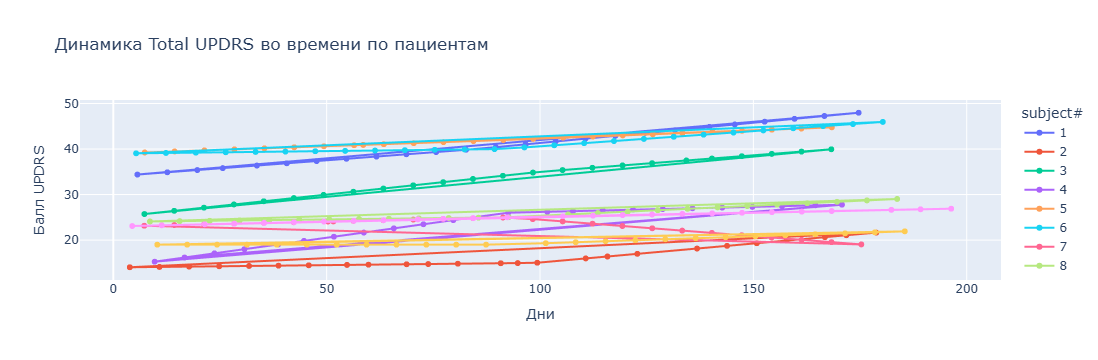

In [34]:
# Выберем первых 10 пациентов для наглядности
sample_patients = df['subject#'].unique()[:10]
df_sample = df[df['subject#'].isin(sample_patients)]

fig = px.line(df_sample, x="test_time", y="total_UPDRS", color="subject#",
              title="Динамика Total UPDRS во времени по пациентам",
              labels={"test_time": "Дни", "total_UPDRS": "Балл UPDRS"},
              markers=True)
fig.show()

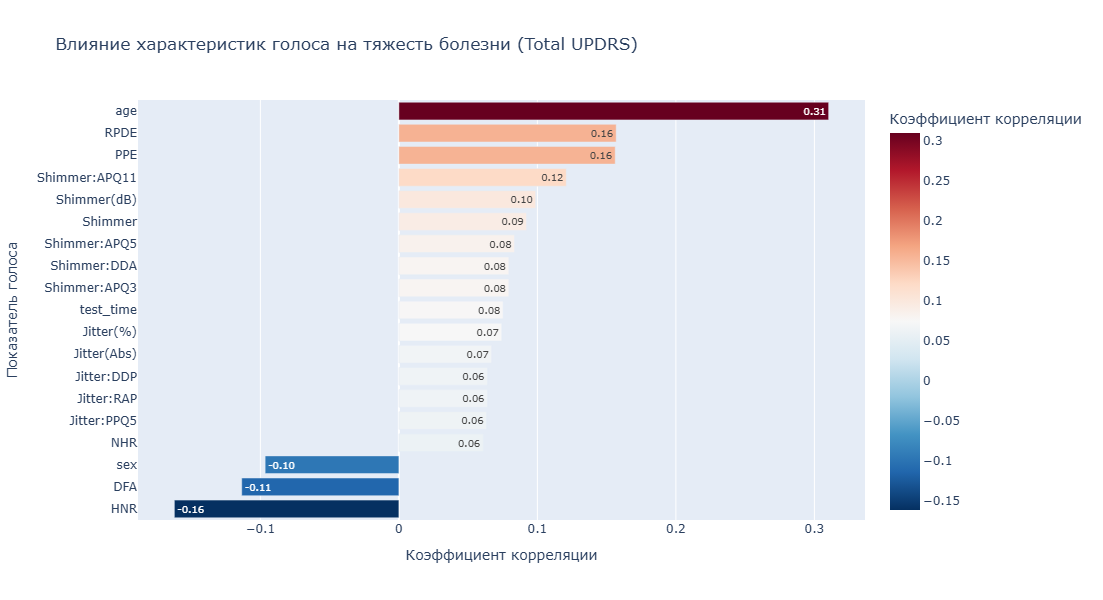

In [36]:
# Рассчитываем корреляцию всех признаков с total_UPDRS
correlations = df.corr()['total_UPDRS'].drop(['total_UPDRS', 'motor_UPDRS', 'subject#']).sort_values()

# Создаем DataFrame для Plotly
corr_df = pd.DataFrame({
    'Feature': correlations.index,
    'Correlation': correlations.values
})

# Строим график
fig_corr = px.bar(corr_df, 
                   x='Correlation', 
                   y='Feature', 
                   orientation='h',
                   title="Влияние характеристик голоса на тяжесть болезни (Total UPDRS)",
                   labels={'Correlation': 'Коэффициент корреляции', 'Feature': 'Показатель голоса'},
                   color='Correlation', 
                   color_continuous_scale='RdBu_r', # Красный - сильная связь, Синий - слабая
                   text_auto='.2f')

fig_corr.update_layout(yaxis={'categoryorder':'total ascending'}, height=600)
fig_corr.show()

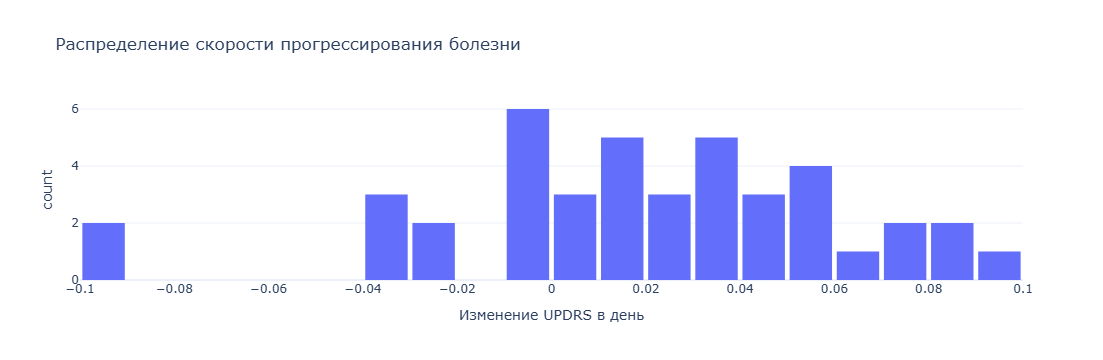

In [41]:
fig_hist = px.histogram(
    progression_df,
    x="progression_rate",
    nbins=30,
    title="Распределение скорости прогрессирования болезни",
    labels={'progression_rate': 'Изменение UPDRS в день'}
)

fig_hist.update_layout(
    bargap=0.1,
    template="plotly_white"
)

fig_hist.show()



In [42]:
# Определяем признаки (X) и цели (y)
# Удаляем служебную информацию и обе цели из признаков
X = df.drop(columns=['subject#', 'motor_UPDRS', 'total_UPDRS', 'progression_rate'])
y = df['total_UPDRS']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование (очень важно для Jitter/Shimmer)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Предсказание
y_pred = model.predict(X_test_scaled)

# Оценка качества
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Средняя абсолютная ошибка (MAE): {mae:.2f} баллов UPDRS")
print(f"Точность модели (R2 score): {r2:.2f}")

Средняя абсолютная ошибка (MAE): 0.72 баллов UPDRS
Точность модели (R2 score): 0.98


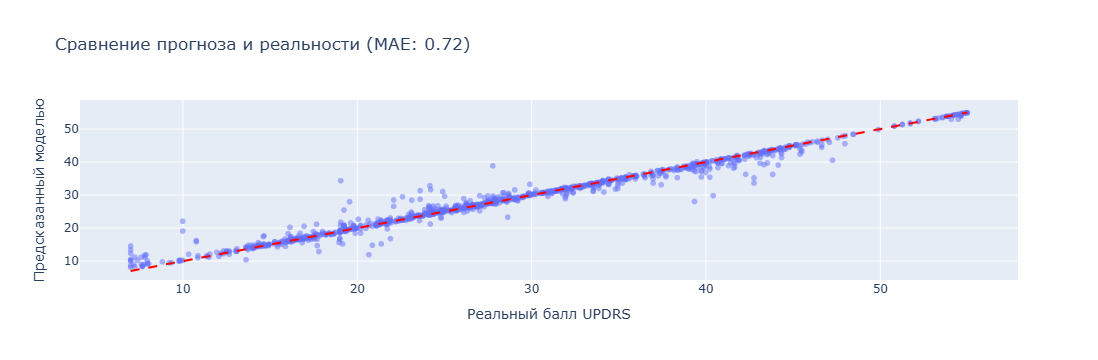

In [44]:
fig_res = px.scatter(x=y_test, y=y_pred, 
                     labels={'x': 'Реальный балл UPDRS', 'y': 'Предсказанный моделью'},
                     title=f"Сравнение прогноза и реальности (MAE: {mae:.2f})",
                     opacity=0.5)
# Добавим линию идеального предсказания
fig_res.add_shape(type="line", x0=y_test.min(), y0=y_test.min(), x1=y_test.max(), y1=y_test.max(),
                  line=dict(color="Red", dash="dash"))
fig_res.show()

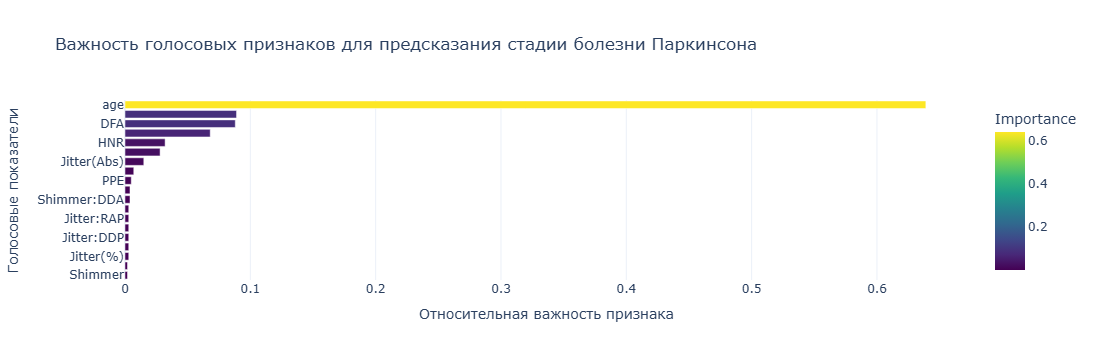

In [46]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=True)

fig_imp = px.bar(importances, x='Importance', y='Feature', orientation='h',
                 title='Какие показатели голоса важнее всего для предсказания стадии болезни?',
                 color='Importance', color_continuous_scale='Viridis')
fig_imp.show()

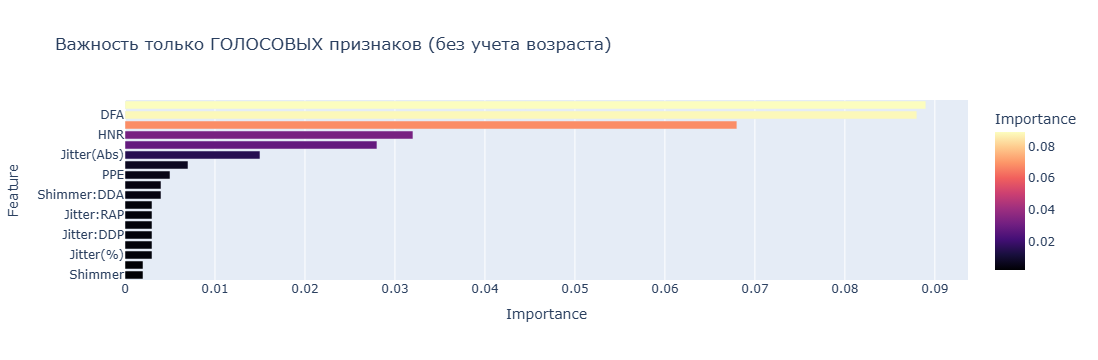

In [47]:
# Удаляем age из importances, чтобы увидеть масштаб остальных
importances_no_age = importances[importances['Feature'] != 'age']

fig_imp_voice = px.bar(importances_no_age, x='Importance', y='Feature', orientation='h',
                 title='Важность только ГОЛОСОВЫХ признаков (без учета возраста)',
                 color='Importance', color_continuous_scale='Magma')
fig_imp_voice.show()

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pandas as pd

# Создаем словарь моделей для удобства сравнения
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVR (Support Vector)": SVR(kernel='rbf')
}

# Список для хранения результатов
results = []

In [49]:
for name, model in models.items():
    # Обучаем модель
    model.fit(X_train_scaled, y_train)
    
    # Делаем прогноз
    predictions = model.predict(X_test_scaled)
    
    # Считаем метрики
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(((predictions - y_test) ** 2).mean()) # Root Mean Squared Error
    
    results.append({
        "Model": name,
        "MAE": round(mae, 3),
        "R2 Score": round(r2, 3),
        "RMSE": round(rmse, 3)
    })

# Превращаем результаты в таблицу
results_df = pd.DataFrame(results).sort_values(by="MAE")
results_df

,Model,MAE,R2 Score,RMSE
1,Random Forest,0.718,0.977,1.607
2,Gradient Boosting,3.749,0.790,4.823
3,SVR (Support Vector),6.615,0.290,8.871
0,Linear Regression,8.054,0.158,9.660


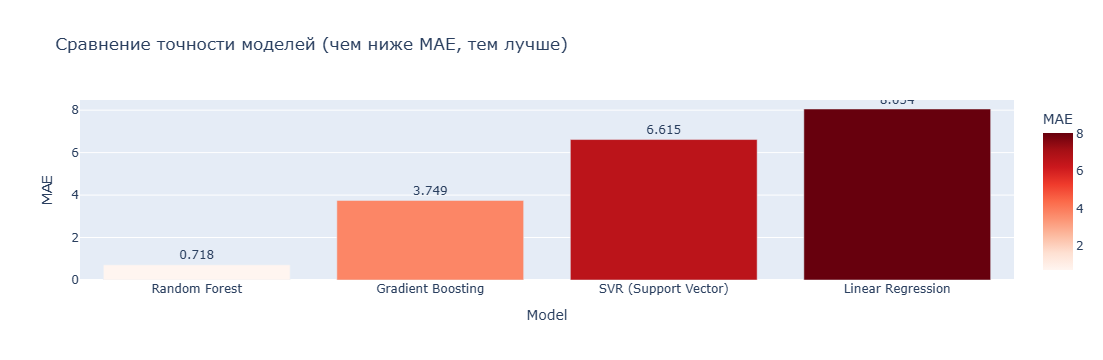

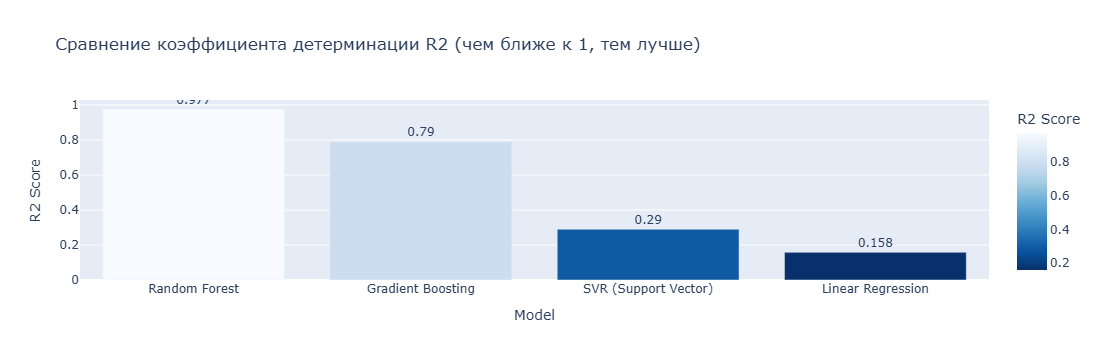

In [50]:
# Визуализация MAE (Средняя абсолютная ошибка)
fig_compare = px.bar(results_df, 
                     x='Model', 
                     y='MAE', 
                     text='MAE',
                     title="Сравнение точности моделей (чем ниже MAE, тем лучше)",
                     color='MAE',
                     color_continuous_scale='Reds')

fig_compare.update_traces(textposition='outside')
fig_compare.show()

# Визуализация R2 Score (Точность соответствия данным)
fig_r2 = px.bar(results_df, 
                x='Model', 
                y='R2 Score', 
                text='R2 Score',
                title="Сравнение коэффициента детерминации R2 (чем ближе к 1, тем лучше)",
                color='R2 Score',
                color_continuous_scale='Blues_r')

fig_r2.update_traces(textposition='outside')
fig_r2.show()

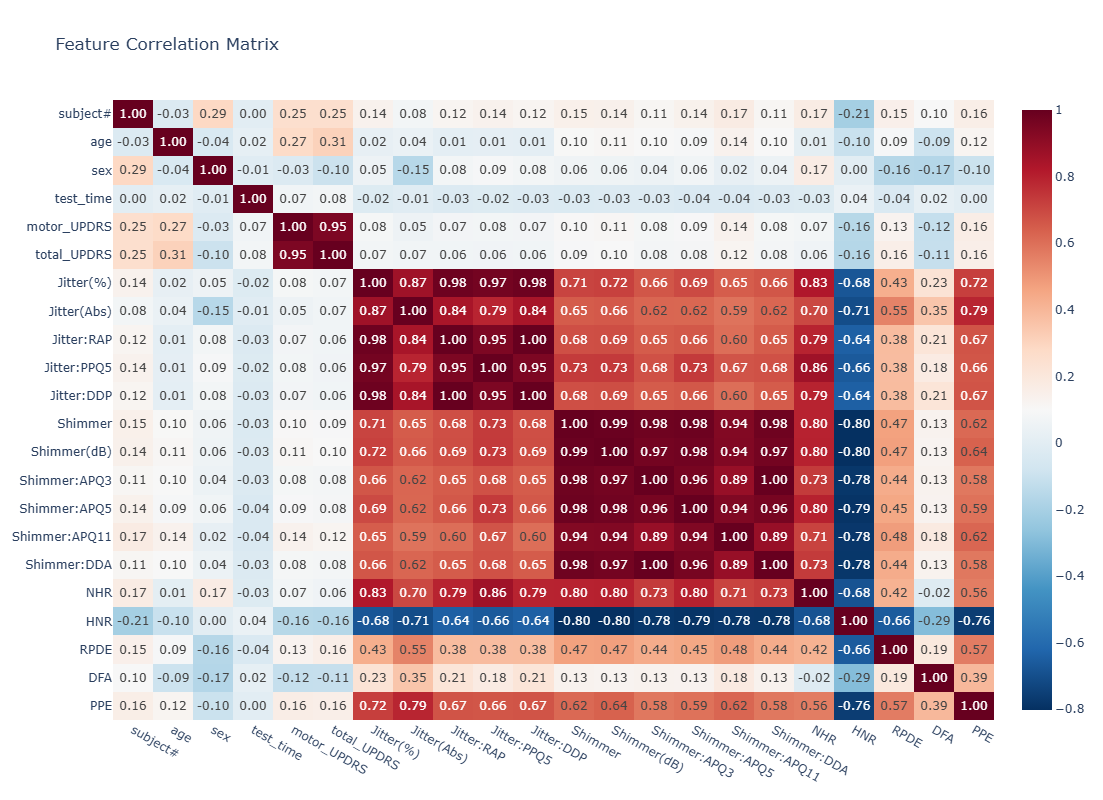

In [26]:
corr_matrix = df.corr()
fig_corr = px.imshow(corr_matrix, 
                text_auto=".2f", 
                aspect="auto", 
                color_continuous_scale='RdBu_r',
                title="Feature Correlation Matrix")
fig_corr.update_layout(height=800)
fig_corr.show()

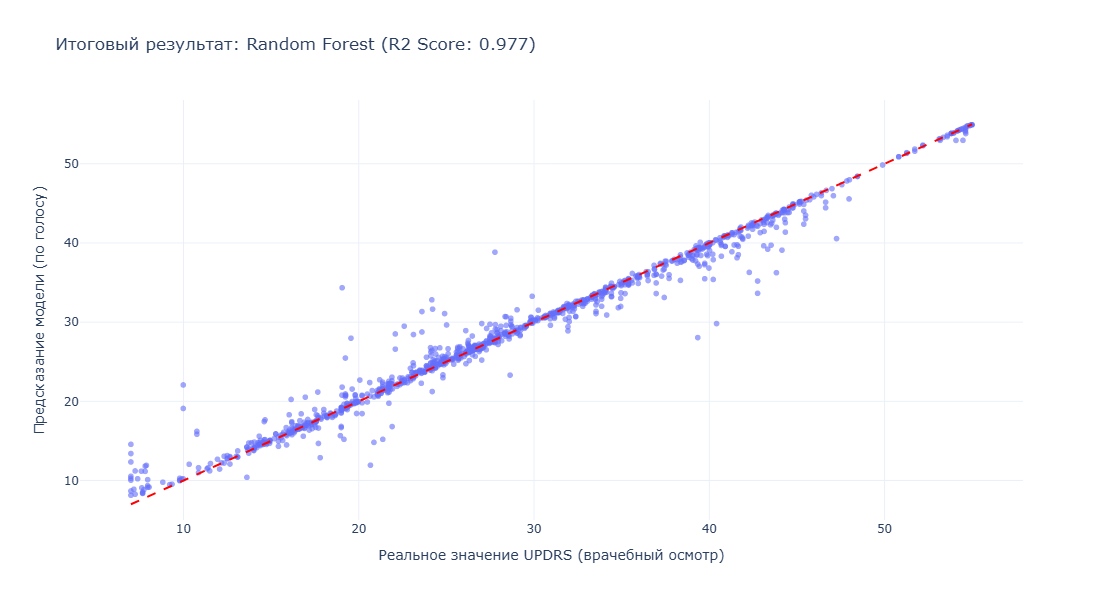

In [51]:
# Берем предсказания именно от Random Forest
best_model = models["Random Forest"]
y_pred_rf = best_model.predict(X_test_scaled)

# Создаем график
fig_final = px.scatter(
    x=y_test, 
    y=y_pred_rf,
    labels={'x': 'Реальное значение UPDRS (врачебный осмотр)', 'y': 'Предсказание модели (по голосу)'},
    title=f"Итоговый результат: Random Forest (R2 Score: 0.977)",
    opacity=0.6,
    template="plotly_white"
)

# Добавляем идеальную линию (если точки на ней — предсказание 100% точное)
fig_final.add_shape(
    type="line", line=dict(color="Red", dash="dash"),
    x0=y_test.min(), y0=y_test.min(), x1=y_test.max(), y1=y_test.max()
)

fig_final.update_layout(width=800, height=600)
fig_final.show()

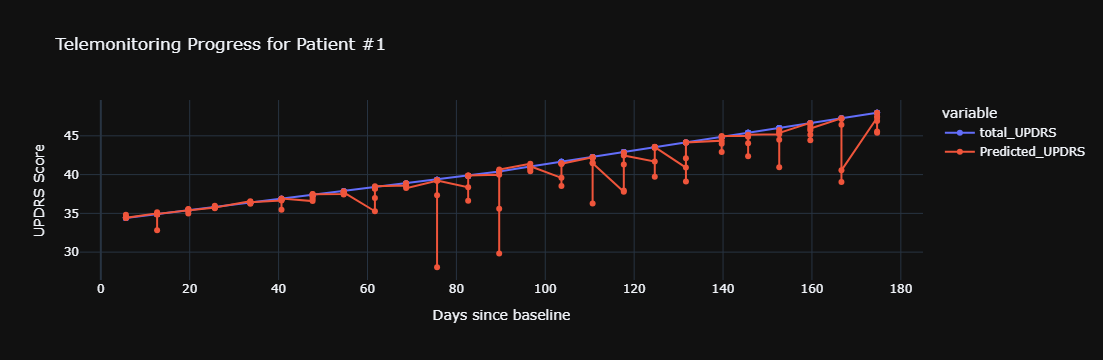

In [32]:
# Selecting Patient ID 1
p_id = 1
patient_data = df[df['subject#'] == p_id].sort_values('test_time')
patient_features_scaled = scaler.transform(patient_data[features])
patient_data['Predicted_UPDRS'] = rf_model.predict(patient_features_scaled)

fig_patient = px.line(patient_data, x='test_time', y=['total_UPDRS', 'Predicted_UPDRS'],
                 markers=True,
                 title=f"Telemonitoring Progress for Patient #{p_id}",
                 labels={'value': 'UPDRS Score', 'test_time': 'Days since baseline'},
                 template="plotly_dark")

fig_patient.update_layout(hovermode="x unified")
fig_patient.show()

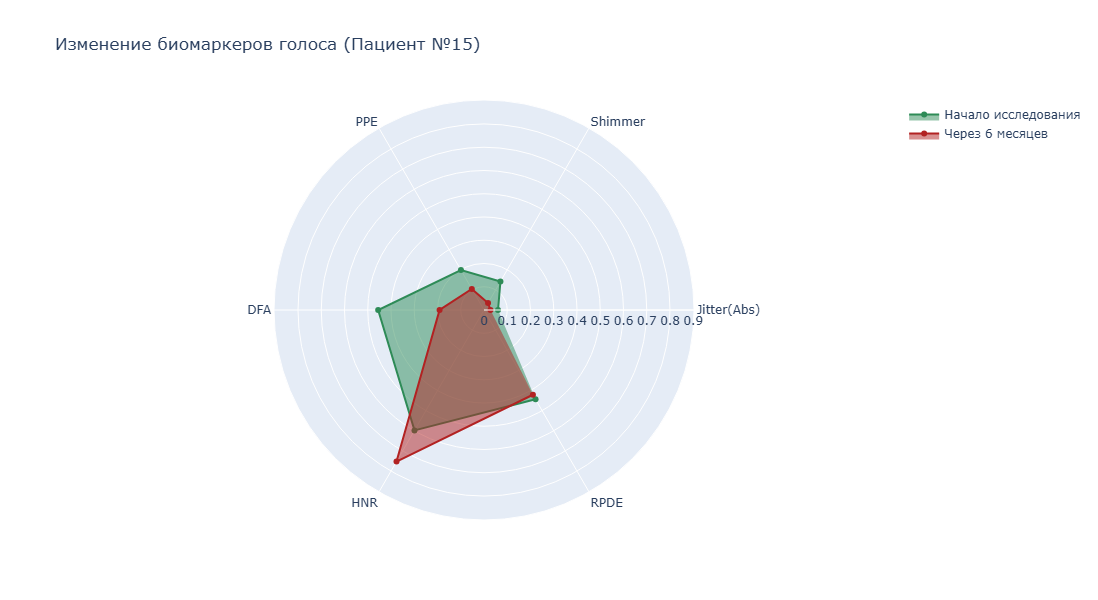

In [122]:
# Выберем самые важные и разные показатели для "портрета"
voice_checks = ['Jitter(Abs)', 'Shimmer', 'PPE', 'DFA', 'HNR', 'RPDE']

# Создаем копию данных для визуализации и нормализуем их
df_radar = df.copy()
for col in voice_checks:
    df_radar[col] = (df_radar[col] - df_radar[col].min()) / (df_radar[col].max() - df_radar[col].min())

# Выбираем пациента (например, №1 или попробуйте №10, если №1 слишком стабилен)
p_id = 15
p_data = df_radar[df_radar['subject#'] == p_id].sort_values('test_time')

# Берем среднее за первую неделю и за последнюю неделю, чтобы убрать случайные шумы
start_state = p_data.iloc[:10][voice_checks].mean()
end_state = p_data.iloc[-10:][voice_checks].mean()

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=start_state.values,
      theta=voice_checks,
      fill='toself',
      name='Начало исследования',
      line_color='seagreen'
))
fig.add_trace(go.Scatterpolar(
      r=end_state.values,
      theta=voice_checks,
      fill='toself',
      name='Через 6 месяцев',
      line_color='firebrick'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, max(start_state.max(), end_state.max()) * 1.2] # Авто-масштаб: зум в 1.2 раза от максимума
    )),
  showlegend=True,
  title=f"Изменение биомаркеров голоса (Пациент №{p_id})",
  height=600
)

fig.show()

In [124]:
def get_patient_summary(p_id):
    p_data = df[df['subject#'] == p_id].sort_values('test_time')
    features_cols = X.columns.tolist()
    
    start_mean = p_data.iloc[:10][features_cols].mean()
    end_mean = p_data.iloc[-10:][features_cols].mean()
    
    # Подготовка данных для модели
    start_df = pd.DataFrame([start_mean], columns=features_cols)
    end_df = pd.DataFrame([end_mean], columns=features_cols)
    
    updrs_start = models["Random Forest"].predict(scaler.transform(start_df))[0]
    updrs_end = models["Random Forest"].predict(end_scaled := scaler.transform(end_df))[0]
    
    updrs_diff = updrs_end - updrs_start
    real_start = p_data.iloc[:10]['total_UPDRS'].mean()
    real_end = p_data.iloc[-10:]['total_UPDRS'].mean()

    print(f"--- АНАЛИЗ ПАЦИЕНТА №{p_id} ---")
    print(f"Прогноз UPDRS в начале: {updrs_start:.2f} (Реальный: {real_start:.2f})")
    print(f"Прогноз UPDRS через 6 мес: {updrs_end:.2f} (Реальный: {real_end:.2f})")
    print("-" * 55)

    if updrs_diff > 2:
        status = "⚠️ ВНИМАНИЕ: Наблюдается прогрессирование болезни."
    elif updrs_diff < -2:
        status = "✅ ПОЛОЖИТЕЛЬНАЯ ДИНАМИКА: Состояние улучшилось."
    else:
        status = "🟢 СТАБИЛЬНОСТЬ: Значительных изменений не обнаружено."
    
    print(status)
    print("\nДетальные изменения в голосе (Биомаркеры):")
    
    for feat in voice_checks:
        change = ((end_mean[feat] - start_mean[feat]) / start_mean[feat]) * 100
        direction = "повысился" if change > 0 else "понизился"
        
        # НОВАЯ ЛОГИКА ИНТЕРПРЕТАЦИИ:
        # Для HNR и DFA: повышение (>) — это ХОРОШО 👍
        # Для остальных (PPE, RPDE, Jitter, Shimmer): повышение (>) — это ПЛОХО 👎
        
        if feat in ['HNR', 'DFA']:
            impact = "👍" if change > 0 else "👎"
        else:
            impact = "👍" if change < 0 else "👎"
            
        print(f" {impact} {feat:<12} {direction:<10} на {abs(change):.1f}%")

# Тестируем
get_patient_summary(15)

--- АНАЛИЗ ПАЦИЕНТА №15 ---
Прогноз UPDRS в начале: 12.23 (Реальный: 13.90)
Прогноз UPDRS через 6 мес: 22.87 (Реальный: 23.06)
-------------------------------------------------------
⚠️ ВНИМАНИЕ: Наблюдается прогрессирование болезни.

Детальные изменения в голосе (Биомаркеры):
 👍 Jitter(Abs)  понизился  на 49.6%
 👍 Shimmer      понизился  на 69.7%
 👍 PPE          понизился  на 40.8%
 👎 DFA          понизился  на 13.8%
 👍 HNR          повысился  на 24.0%
 👍 RPDE         понизился  на 3.6%


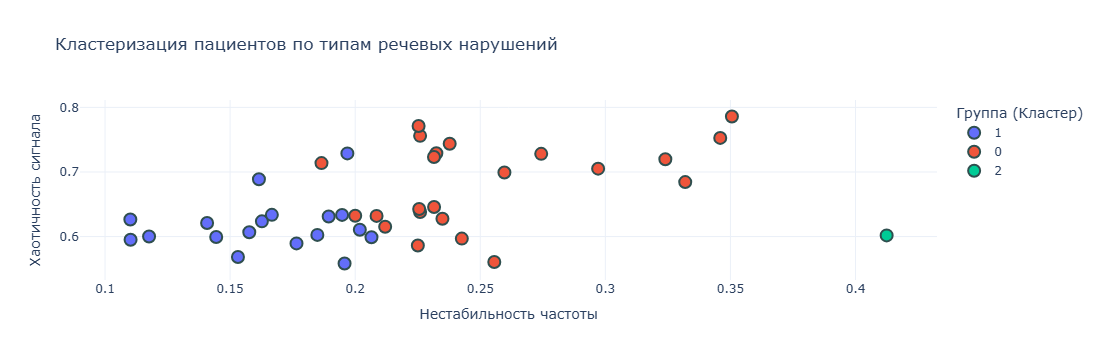

In [102]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Теперь voice_checks определен выше и NameError не будет
patient_profiles = df.groupby('subject#')[voice_checks].mean()

scaler_kmeans = StandardScaler()
profiles_scaled = scaler_kmeans.fit_transform(patient_profiles)

# Делим на 3 кластера (например: легкая, средняя и тяжелая стадии)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
patient_profiles['Cluster'] = kmeans.fit_predict(profiles_scaled)

# Визуализация кластеров
fig_clusters = px.scatter(
    patient_profiles, 
    x='PPE', 
    y='DFA', 
    color=patient_profiles['Cluster'].astype(str),
    title="Кластеризация пациентов по типам речевых нарушений",
    labels={'color': 'Группа (Кластер)', 'PPE': 'Нестабильность частоты', 'DFA': 'Хаотичность сигнала'},
    hover_data=[patient_profiles.index],
    template="plotly_white"
)

fig_clusters.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')))
fig_clusters.show()